In [7]:
import matplotlib.pyplot as plt
import random

def show_examples(dataset, num=5, figsize=(20, 6)):
    fig, axs = plt.subplots(1, num, figsize=figsize)  
    
    for i in range(num):
        idx = random.randint(0, len(dataset) - 1)  
        img, label = dataset[idx] 
        
        img_np = img.squeeze(0).numpy()  
        axs[i].imshow(img_np, cmap='gray')  
        axs[i].set_title('lesion' if label == 1 else 'no lesion')  
        axs[i].axis('off')  # Hide axis
        
    plt.show()

In [2]:
import os
import random
import numpy as np
import nibabel as nib
from glob import glob
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms.functional as TF
from torchvision.transforms import Resize
import torch.nn.functional as F
from skimage.measure import shannon_entropy
import matplotlib.pyplot as plt
# Path to your data folder
DATA_PATH = "/home/anastasiasinger/Downloads/data_an_et_al_2022/data_repository/data_charite"

# --- Dataset helper ---
def get_valid_subjects(data_path):
    subjects = []
    for subject_path in glob(os.path.join(data_path, '*')):
        mask_path = os.path.join(subject_path, 'masklesion_manual.nii')
        t2_path = os.path.join(subject_path, 't2.nii')
        if os.path.exists(mask_path) and os.path.exists(t2_path):
            subjects.append(subject_path)
    print(f"✅ Found {len(subjects)} valid mouse scans.")
    return subjects

# --- Preprocessing functions ---
def load_nifti(path):
    img = nib.load(path).get_fdata()
    return img

def normalize(image):
    image = (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-8)
    return image

class MRIDatasetLabel(Dataset):
    def __init__(self, subject_paths, resize_to=(256, 256), augment=True, reduce_slices=False):
        self.subject_paths = subject_paths
        self.resize_to = resize_to
        self.augment = augment
        self.reduce_slices = reduce_slices
        self.slice_infos = self._prepare_slices()
        self.valid_slices = self._filter_invalid_slices()

    def _prepare_slices(self):
        slice_infos = []
        for subject_path in self.subject_paths:
            img = load_nifti(os.path.join(subject_path, 't2.nii'))
            mask = load_nifti(os.path.join(subject_path, 'masklesion_manual.nii'))
            axis = 2     #Only Z-axis slices
            num_slices = img.shape[axis]
            for idx in range(num_slices):
                slice_infos.append((subject_path, axis, idx))
        # slice reduction (inactive)
        if self.reduce_slices:
            random.shuffle(slice_infos)  
            num_slices = len(slice_infos)
            reduced_num = random.randint(num_slices // 6, num_slices // 5)  
            slice_infos = slice_infos[:reduced_num]  
            print(f"✅ Reduced slices from {num_slices} to {len(slice_infos)}")

        return slice_infos
    #Ensuring that our images have valuable information
    def _filter_invalid_slices(self):
        valid_slices = []
        for subject_path, axis, slice_idx in self.slice_infos:
            img_path = os.path.join(subject_path, 't2.nii')
            mask_path = os.path.join(subject_path, 'masklesion_manual.nii')
            img_3d = load_nifti(img_path)
            mask_3d = load_nifti(mask_path)
            img_slice, mask_slice = self._get_slice(img_3d, mask_3d, axis, slice_idx)
            img_slice = normalize(img_slice)
            entropy = shannon_entropy(img_slice)
            if entropy > 10:
                valid_slices.append((subject_path, img_path, mask_path, axis, slice_idx))
        print(f"✅ Filtered down to {len(valid_slices)} valid slices from {len(self.slice_infos)} candidates")      
        return valid_slices
        
        

    def __len__(self):
        return len(self.valid_slices)

    def __getitem__(self, idx):
        # Retrieve information about the slice
        subject_path, img_path, mask_path, axis, slice_idx = self.valid_slices[idx]
        
        # Cache slices in memory, avoiding repeated disk access
        img_3d = load_nifti(img_path)
        mask_3d = load_nifti(mask_path)

        img_slice, mask_slice = self._get_slice(img_3d, mask_3d, axis, slice_idx)
        img_slice = normalize(img_slice)
        # Convert to tensor
        img_tensor = torch.tensor(img_slice, dtype=torch.float32).unsqueeze(0)
        
        # Resize
        if self.resize_to is not None:
            img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=self.resize_to, mode='bilinear', align_corners=False).squeeze(0)

        # Label: 1 if any lesion present, else 0
        label = 1 if np.sum(mask_slice) > 0 else 0
        label = torch.tensor(label, dtype=torch.long)

        # Apply augmentation if enabled
        if self.augment:
            if random.random() > 0.5:
                img_tensor = TF.hflip(img_tensor)
            if random.random() > 0.5:
                angle = random.uniform(-15, 15)
                img_tensor = TF.rotate(img_tensor, angle)

        return img_tensor, label

    def _get_slice(self, img_3d, mask_3d, axis, slice_idx):
        # Extract the slice based on axis and slice index
        if axis == 0:
            return img_3d[slice_idx, :, :], mask_3d[slice_idx, :, :]
        elif axis == 1:
            return img_3d[:, slice_idx, :], mask_3d[:, slice_idx, :]
        elif axis == 2:
            return img_3d[:, :, slice_idx], mask_3d[:, :, slice_idx]



        
def get_intra_subject_split(subjects):
    
    train_subjects, temp_subjects = train_test_split(subjects, test_size=0.2, random_state=42)
    val_subjects, test_subjects = train_test_split(temp_subjects, test_size=0.5, random_state=42)
    
    train_dataset = MRIDatasetLabel(train_subjects, augment=True)
    val_dataset = MRIDatasetLabel(val_subjects)
    test_dataset = MRIDatasetLabel(test_subjects)

    return train_dataset, val_dataset, test_dataset

# --- Main Execution ---
subjects = get_valid_subjects(DATA_PATH)

# Get dataset splits
intra_train, intra_val, intra_test = get_intra_subject_split(subjects)

# Create loaders
BATCH_SIZE = 64

intra_loader = DataLoader(intra_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

for imgs, labels in intra_loader:
    print(imgs.shape) 
    print(labels.shape)  
    print(labels.unique())  
    break

✅ Found 331 valid mouse scans.
✅ Filtered down to 5712 valid slices from 8448 candidates
✅ Filtered down to 772 valid slices from 1056 candidates
✅ Filtered down to 765 valid slices from 1088 candidates
torch.Size([64, 1, 256, 256])
torch.Size([64])
tensor([0, 1])


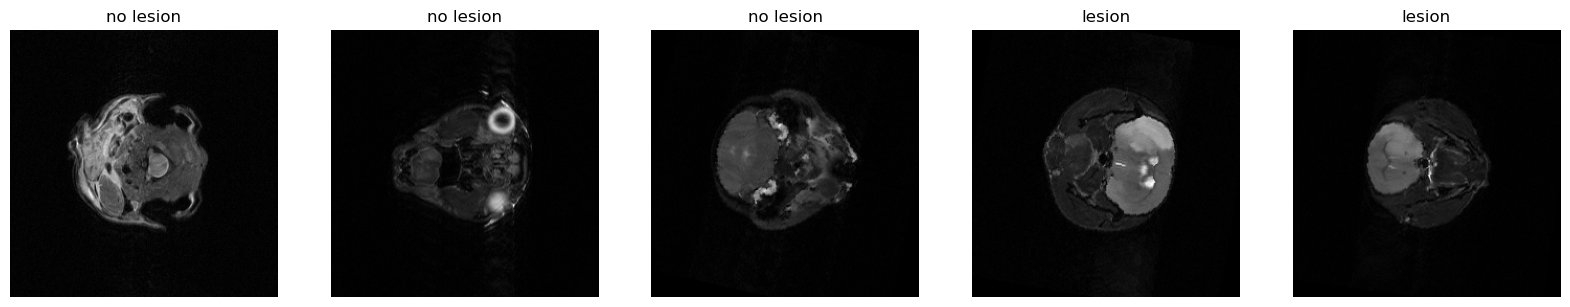

In [9]:
show_examples(intra_test)

In [5]:
# --- IMPORTS ---
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(intra_train, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(intra_val, batch_size=64, num_workers=8, pin_memory=True)
test_loader = DataLoader(intra_test, batch_size=64, num_workers=8, pin_memory=True)


# --- 2. SIMPLE CNN CLASSIFIER ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)  # flatten
        return self.fc(x)


model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# --- 3. TRAINING LOOP ---
def train_classifier(model, train_loader, val_loader, epochs=100, save_path=os.path.expanduser("~/best_model_updated_3.pth")):
    train_loss_list, val_loss_list = [], []
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # Make sure the directory exists
    os.makedirs(os.path.dirname(save_path), exist_ok=True)

    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            preds = model(imgs)
            loss = criterion(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
                preds = model(imgs)
                val_loss += criterion(preds, labels).item()

        train_loss = total_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)

        print(f"📚 Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()
            torch.save(best_model_state_dict, save_path)
            print(f"💾 Best model saved at epoch {epoch+1} with Val Loss = {best_val_loss:.4f}")

    
        scheduler.step()

    model.load_state_dict(torch.load(save_path))
    
    print("✔️ Training complete. Loaded the best model based on validation loss.")
    
    return train_loss_list, val_loss_list
    
train_loss, val_loss = train_classifier(model, train_loader, val_loader, epochs=100)

📚 Epoch 1: Train Loss = 0.5495, Val Loss = 0.5680
💾 Best model saved at epoch 1 with Val Loss = 0.5680
📚 Epoch 2: Train Loss = 0.3899, Val Loss = 0.7901
📚 Epoch 3: Train Loss = 0.3298, Val Loss = 0.3285
💾 Best model saved at epoch 3 with Val Loss = 0.3285
📚 Epoch 4: Train Loss = 0.3121, Val Loss = 0.6021
📚 Epoch 5: Train Loss = 0.3020, Val Loss = 0.4746
📚 Epoch 6: Train Loss = 0.2889, Val Loss = 0.4307
📚 Epoch 7: Train Loss = 0.2893, Val Loss = 0.3084
💾 Best model saved at epoch 7 with Val Loss = 0.3084
📚 Epoch 8: Train Loss = 0.2821, Val Loss = 0.2976
💾 Best model saved at epoch 8 with Val Loss = 0.2976
📚 Epoch 9: Train Loss = 0.2790, Val Loss = 0.5122
📚 Epoch 10: Train Loss = 0.2709, Val Loss = 0.3494
📚 Epoch 11: Train Loss = 0.2597, Val Loss = 0.4087
📚 Epoch 12: Train Loss = 0.2571, Val Loss = 0.3411
📚 Epoch 13: Train Loss = 0.2679, Val Loss = 0.2799
💾 Best model saved at epoch 13 with Val Loss = 0.2799
📚 Epoch 14: Train Loss = 0.2602, Val Loss = 0.2606
💾 Best model saved at epoch 1

In [3]:
# --- SEGMENTATION-BASED CLASSIFICATION ---

import gc

def segment_based_classification(segmentation_model, dataloader, device, pixel_threshold):
    preds_all = []
    trues_all = []

    try:
        segmentation_model.eval()
        with torch.no_grad():
            for inputs, labels in dataloader:
                gc.collect()
                torch.cuda.empty_cache()
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = segmentation_model(inputs)
                outputs = outputs.cpu().numpy()
                
                for i, output in enumerate(outputs):
                    output = (output > 0.5).astype(np.uint8)
                    pred_label = 1 if np.sum(output) > pixel_threshold else 0
                    preds_all.append(pred_label)

                trues_all.extend(labels.cpu().tolist())
    except Exception as e:
        print(f"Error during classification: {e}")
    
    return trues_all, preds_all


In [4]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)))
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)  # flatten
        return self.fc(x)

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.encoder1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)pixel_threshold = find_optimal_pixel_threshold(model_seg, val_loader, device)


        self.bottleneck = conv_block(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.decoder2 = conv_block(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.decoder1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.up2(bottleneck)
        dec2 = self.decoder2(torch.cat([dec2, enc2], dim=1))
        dec1 = self.up1(dec2)
        dec1 = self.decoder1(torch.cat([dec1, enc1], dim=1))
        return torch.sigmoid(self.final(dec1))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_seg = UNet()
model_cnn = SimpleCNN()
state_dict = torch.load('/home/anastasiasinger/best_model_CNN_Zaxis.pth')
new_state_dict = {k.replace("_orig_mod.", ""): v for k, v in state_dict.items()}
model_cnn.load_state_dict(new_state_dict)
model_seg.load_state_dict(torch.load('/home/anastasiasinger/Documents/checkpoint/best_model_diceloss.pth')) 
model_seg.to(device)
model_cnn.to(device)

SimpleCNN(
  (net): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [18]:
import torchvision.transforms as transforms

torch.cuda.empty_cache()

train_loader = DataLoader(intra_train, batch_size=64, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(intra_val, batch_size=64, num_workers=8, pin_memory=True)
test_loader = DataLoader(intra_test, batch_size=64, num_workers=8, pin_memory=True)


In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#finding pixel threshold using validation dataset

def find_optimal_pixel_threshold(segmentation_model, dataloader, device):
    segmentation_model.eval()
    pixel_counts = []
    true_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            gc.collect()
            torch.cuda.empty_cache()
            
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = segmentation_model(inputs)
            outputs = outputs.cpu().numpy()

            for i, output in enumerate(outputs):
                output = (output > 0.5).astype(np.uint8)
                pixel_count = np.sum(output)
                pixel_counts.append(pixel_count)
                true_labels.append(labels[i].item())
                
    pixel_counts = np.array(pixel_counts)
    true_labels = np.array(true_labels)
    
    thresholds = np.arange(0, pixel_counts.max() + 1, 10)
    best_threshold = 0
    best_f1 = 0.0
    for threshold in thresholds:
        predicted_labels = (pixel_counts > threshold).astype(int)
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold



In [132]:

# --- EVALUATION METRICS ---
def evaluate(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average='weighted'),
        "Recall": recall_score(y_true, y_pred, average='weighted'),
        "F1 Score": f1_score(y_true, y_pred, average='weighted')
    }


# --- CNN CLASSIFIER EVALUATION ---
model_cnn.to(device)
model_cnn.eval()
y_true_cnn, y_pred_cnn = [], []

with torch.no_grad():
    for imgs, labels in test_loader:
        labels = labels.to(device)
        imgs = imgs.to(device)
        outputs = model_cnn(imgs)
        preds = torch.argmax(outputs, dim=1)
        y_true_cnn.extend(labels.tolist())
        y_pred_cnn.extend(preds.cpu().tolist())

# --- SEGMENTATION-BASED EVALUATION ---


pixel_threshold = find_optimal_pixel_threshold(model_seg, val_loader, device)

y_true_seg, y_pred_seg = segment_based_classification(model_seg, test_loader, device, pixel_threshold)

# --- COMPARE RESULTS ---
print("\n📈 CNN Classification Metrics:")
for k, v in evaluate(y_true_cnn, y_pred_cnn).items():
    print(f"{k}: {v:.4f}")

print("\n📈 Segmentation-Based Classification Metrics:")
for k, v in evaluate(y_true_seg, y_pred_seg).items():
    print(f"{k}: {v:.4f}")



📈 CNN Classification Metrics:
Accuracy: 0.9150
Precision: 0.9160
Recall: 0.9150
F1 Score: 0.9154

📈 Segmentation-Based Classification Metrics:
Accuracy: 0.8418
Precision: 0.8454
Recall: 0.8418
F1 Score: 0.8431


In [26]:
def visualise_prediction(model, dataloader, num_images=9):
    model.eval()
    class_names = ["No lesion", "Lesion"]
    all_data = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            preds = model(imgs).argmax(dim=1)
            imgs = imgs.cpu()
            preds = preds.cpu()
            labels = labels.cpu()

            for i in range(imgs.size(0)):
                all_data.append((imgs[i], preds[i], labels[i]))

    selected = random.sample(all_data, min(num_images, len(all_data)))

    plt.figure(figsize=(12, 12))
    for idx, (img, pred, label) in enumerate(selected):
        plt.subplot(int(num_images ** 0.5), int(num_images ** 0.5), idx + 1)
        img_pil = TF.to_pil_image(img)
        plt.imshow(img_pil, cmap="gray")
        color = "green" if pred == label else "red"
        plt.title(f"P: {class_names[pred]}\nT: {class_names[label]}", color=color, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()



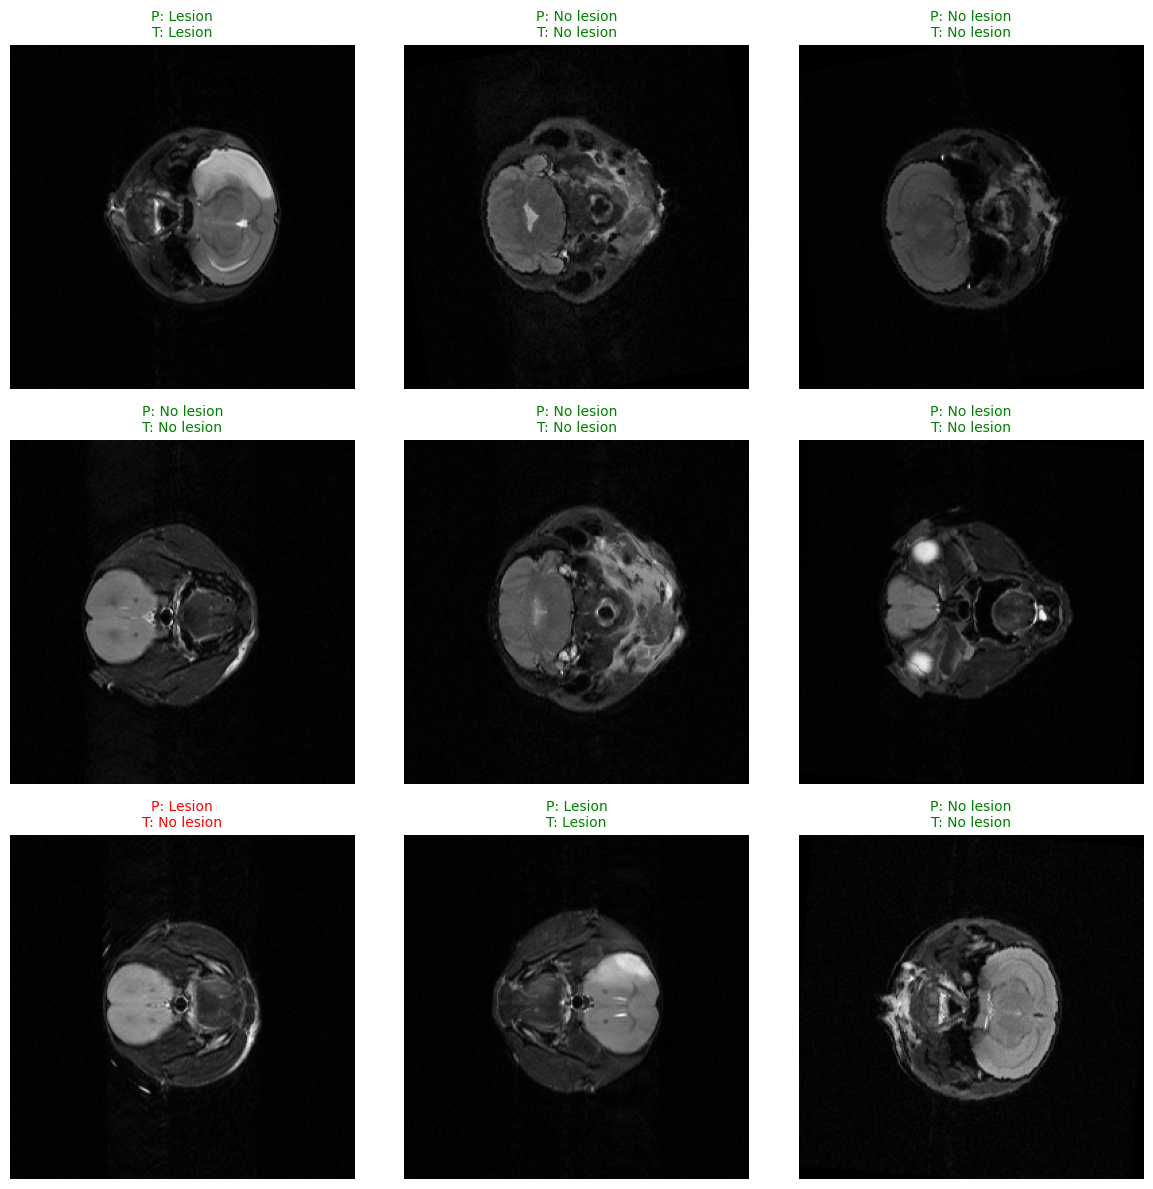

In [28]:
visualise_prediction(model_cnn, test_loader, num_images=9)

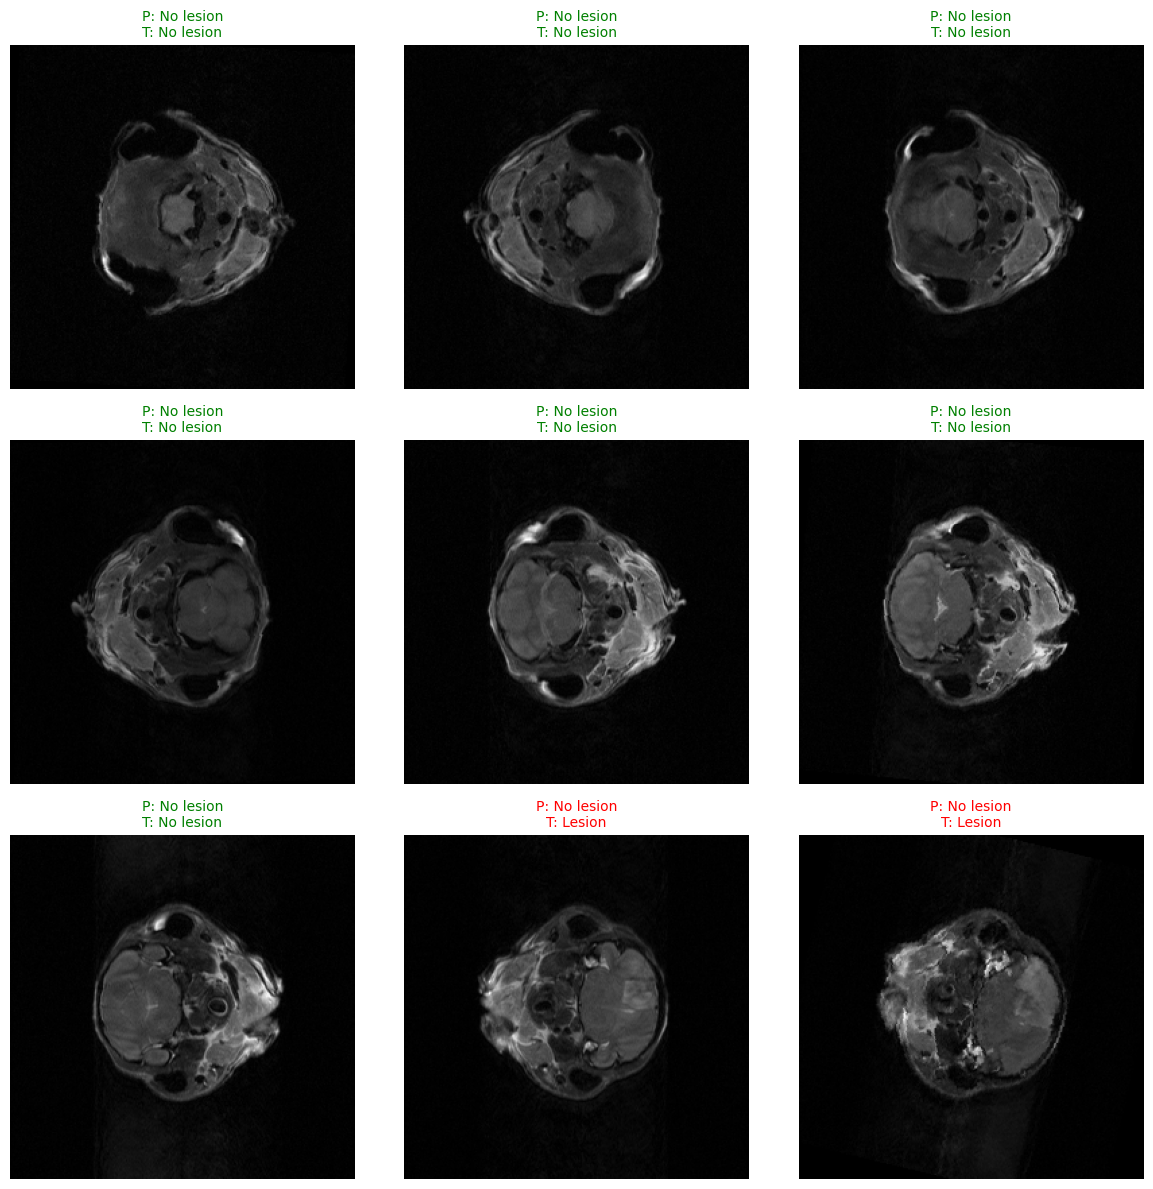

In [22]:

def visualise_prediction_seg(model, dataloader, device, num_images=9, pixel_threshold=pixel_threshold):

    model.eval()
    class_names = ["No lesion", "Lesion"]
    results = []

    with torch.no_grad():
        count = 0
        for imgs, masks in dataloader:
            for i in range(imgs.size(0)):
                gc.collect()
                torch.cuda.empty_cache()

                img = imgs[i].unsqueeze(0).to(device)  # Shape: [1, C, H, W]
                mask = masks[i]

                output = model(img)
                pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu()

                img = img.squeeze(0).cpu()

                pred_label = 1 if pred_mask.sum().item() > pixel_threshold else 0
                true_label = 1 if mask.sum().item() > 0 else 0

                results.append((img, pred_label, true_label))
                count += 1
                if count >= num_images:
                    break
            if count >= num_images:
                break

    plt.figure(figsize=(12, 12))
    grid_size = int(num_images ** 0.5)
    for idx, (img, pred_label, true_label) in enumerate(results):
        plt.subplot(grid_size, grid_size, idx + 1)
        plt.imshow(TF.to_pil_image(img), cmap="gray")
        color = "green" if pred_label == true_label else "red"
        plt.title(f"P: {class_names[pred_label]}\nT: {class_names[true_label]}", color=color, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualise_prediction_seg(model_seg, test_loader, device, num_images=9)
